In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/DATA/lucaa/software/CLoNe')

from matplotlib import rc
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

from clone import CLoNe
from plot import plot_clusters
from structural_utils import load_md_args, show_cluster_info

import mdtraj
import pyemma
import seaborn as sns
print(__doc__)
start = time.time()

Automatically created module for IPython interactive environment


In [2]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=6  # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 200  # number of bins for PC hist
# Simulations and topology 
trj_apo='apo/trjcat_md_esyt_apo_center_pbcmol_fit_rot_trans_CA_after10ns_stride10.xtc'   # apo traj
trj_holo='holo/trjcat_md_esyt_holo_center_pbcmol_fit_rot_trans_CA_after10ns_stride10.xtc'# holo traj
trj_tot='esyt_tot.xtc'   # concatenated total traj

topo_apo='apo/apo.pdb'  # pdb or gro of apo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA and resid 4 to 179"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=176   # number of residues (still manual insertion, i know...)
feat="None"
resmin=4
resmax=179
output_folder = "results"

apo_name="apo"
holo_name="holo"
tot_name="tot"

In [3]:
def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords

def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn

def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)

In [4]:
struct_ens = mdtraj.load("apo/apo.pdb", top="apo/apo.pdb")
#print(topo_apo)
selection = struct_ens.topology.select("name CA and resid 184 to 362")
#print(len(selection))

/DATA/lucaa/software/anaconda3/envs/cloneenv/lib/python3.7/site-packages/mdtraj/core/trajectory.py:422: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [5]:
# make results folder 
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
# make images folder 
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass
# Calculate PCA
pca_apo, red_dim_coords_apo, orig_coords_apo = calculate_pca(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca)
pca_holo, red_dim_coords_holo, orig_coords_holo = calculate_pca(topo_apo, trj_holo, output_folder, holo_name, at_sel, n_pca)
pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca)


> PCA: 528 => 10 dimension(s) with eigenval.: [0.29478315 0.18881397 0.13522449 0.05490596 0.03773805 0.02773127
 0.02416644 0.01904516 0.01528695 0.01261781]
sum of Variance: 0.8103132
> PCA: 528 => 10 dimension(s) with eigenval.: [0.24933816 0.14353158 0.08648666 0.0539991  0.0428015  0.03354075
 0.02769756 0.02570552 0.0206387  0.01864385]
sum of Variance: 0.7023834
> PCA: 528 => 10 dimension(s) with eigenval.: [0.3868781  0.17234841 0.06890079 0.05066719 0.02969076 0.02449825
 0.01832697 0.01612553 0.01493636 0.01165545]
sum of Variance: 0.79402786


In [6]:
index_apo_end=np.shape(red_dim_coords_apo)[0]
index_tot_end=np.shape(red_dim_coords_tot)[0]

# Figures PC and histograms checking that all pc apo, holo and tot are the similar 

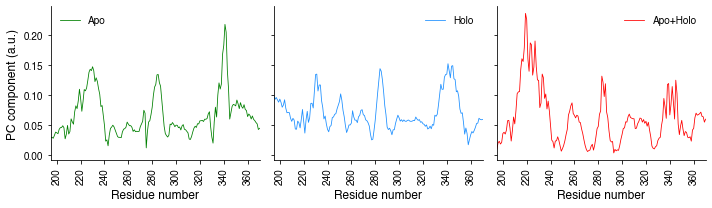

In [19]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True, sharex=True)
tick_spacing = 20
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

ax[0].set_xlim(resmin+191,resmax+191)
ax[0].plot(np.arange(resmin, resmax+1)+191,calc_magn_vector(pca_apo.components_[0]), linewidth=0.8, color='green')
ax[1].plot(np.arange(resmin, resmax+1)+191,calc_magn_vector(pca_holo.components_[0]), linewidth=0.8, color='dodgerblue')
ax[2].plot(np.arange(resmin, resmax+1)+191,calc_magn_vector(pca_tot.components_[0]), linewidth=0.8, color='red')

sns.despine()

ax[0].legend(['Apo'], frameon=False)
ax[1].legend(['Holo'], frameon=False)
ax[2].legend(['Apo+Holo'], frameon=False)

ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
fig.tight_layout()

ax[0]
fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_tot.pdf')

plt.show()

/DATA/lucaa/software/anaconda3/envs/cloneenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


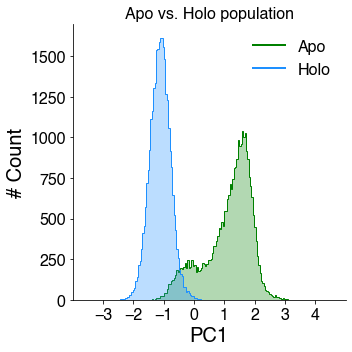

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color='green', lw=2, label='Apo'),Line2D([0], [0], color='dodgerblue', lw=2, label='Holo')]
ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)
ax.set_title("Apo vs. Holo population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_pc.pdf')
plt.show()

# Clustering


In [7]:
#clone_apo = CLoNe(pdc=pdc)
#clone_holo = CLoNe(pdc=pdc)
clone_apoholo = CLoNe(pdc=8)

#clone_apo.fit(red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1)) 
#clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 
clone_apoholo.fit(red_dim_coords_tot[:,0].reshape(-1, 1))   

# Population analysis

In [10]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in clusters:
    
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:index_tot_end] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100])
    #print(label, count_apo, count_holo, count_tot)

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)'])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

# Cluster plots

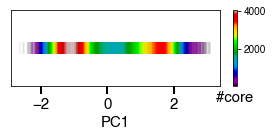

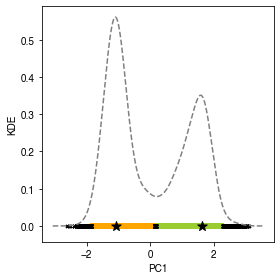

In [9]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
#plot_clusters(clone_apo, red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1), output_folder+'/apo_1',pca_headers[:2] ) 
#plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder+'/holo_1',pca_headers[:2] )
plot_clusters(clone_apoholo, red_dim_coords_tot[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

# Save clusters

In [9]:
# Load trajectories
#struct_apo = mdtraj.load(trj_apo, top=topo_apo)
#struct_holo = mdtraj.load(trj_holo, top=topo_apo)
struct_apoholo = mdtraj.load(trj_tot, top=topo_apo)

In [10]:
unique_labels = range(len(clone_apoholo.centers)) 
folder = output_folder+'/'+tot_name+'_1'

# Save center
[struct_apoholo[center].save(folder+"/Center_%d.pdb"%(center_id + 1)) for center, center_id in zip(clone_apoholo.centers, unique_labels)]
# Save trajs
[struct_apo[clone_apoholo.labels_[0:index_apo_end] == lab].save(folder+"/Cluster_apo_%d.xtc"%(lab + 1)) for lab in unique_labels]
[struct_holo[clone_apoholo.labels_[index_apo_end:] == lab].save(folder+"/Cluster_holo_%d.xtc"%(lab + 1)) for lab in unique_labels]

NameError: name 'struct_apo' is not defined

# Save extreme structures

In [11]:
minframe=[100,-1,-2]
maxframe=[-100,-1,-2]
for frame in zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))):
    if frame[1] != -1:
        if frame[0] < minframe[0]:
            minframe = frame
        if frame[0] > maxframe[0]:
            maxframe = frame

folder = output_folder+'/'+tot_name+'_1'
struct_apoholo[minframe[2]].save(folder+"/extremeleft.pdb")          
struct_apoholo[maxframe[2]].save(folder+"/extremeright.pdb")          


In [11]:
a = sorted(zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))))
a = [el for el in a if el[1] != -1]
a[0]
struct_apoholo[a[0][2]].save(folder+"/extremeleft1.pdb")
struct_apoholo[a[1][2]].save(folder+"/extremeleft2.pdb")
struct_apoholo[a[2][2]].save(folder+"/extremeleft3.pdb")
struct_apoholo[a[3][2]].save(folder+"/extremeleft4.pdb")
struct_apoholo[a[4][2]].save(folder+"/extremeleft5.pdb")
struct_apoholo[a[5][2]].save(folder+"/extremeleft6.pdb")
struct_apoholo[a[6][2]].save(folder+"/extremeleft7.pdb")
struct_apoholo[a[7][2]].save(folder+"/extremeleft8.pdb")
struct_apoholo[a[8][2]].save(folder+"/extremeleft9.pdb")
struct_apoholo[a[9][2]].save(folder+"/extremeleft10.pdb")
struct_apoholo[a[10][2]].save(folder+"/extremeleft11.pdb")
struct_apoholo[a[11][2]].save(folder+"/extremeleft12.pdb")
struct_apoholo[a[12][2]].save(folder+"/extremeleft13.pdb")
struct_apoholo[a[13][2]].save(folder+"/extremeleft14.pdb")
struct_apoholo[a[14][2]].save(folder+"/extremeleft15.pdb")
struct_apoholo[a[15][2]].save(folder+"/extremeleft16.pdb")
struct_apoholo[a[16][2]].save(folder+"/extremeleft17.pdb")
struct_apoholo[a[17][2]].save(folder+"/extremeleft18.pdb")
struct_apoholo[a[18][2]].save(folder+"/extremeleft19.pdb")
struct_apoholo[a[19][2]].save(folder+"/extremeleft20.pdb")

struct_apoholo[a[-1][2]].save(folder+"/extremeright1.pdb")
struct_apoholo[a[-2][2]].save(folder+"/extremeright2.pdb")
struct_apoholo[a[-3][2]].save(folder+"/extremeright3.pdb")
struct_apoholo[a[-4][2]].save(folder+"/extremeright4.pdb") 
struct_apoholo[a[-5][2]].save(folder+"/extremeright5.pdb")
struct_apoholo[a[-6][2]].save(folder+"/extremeright6.pdb")
struct_apoholo[a[-7][2]].save(folder+"/extremeright7.pdb")
struct_apoholo[a[-8][2]].save(folder+"/extremeright8.pdb")
struct_apoholo[a[-9][2]].save(folder+"/extremeright9.pdb")
struct_apoholo[a[-10][2]].save(folder+"/extremeright10.pdb")
struct_apoholo[a[-11][2]].save(folder+"/extremeright11.pdb")
struct_apoholo[a[-12][2]].save(folder+"/extremeright12.pdb")
struct_apoholo[a[-13][2]].save(folder+"/extremeright13.pdb")
struct_apoholo[a[-14][2]].save(folder+"/extremeright14.pdb") 
struct_apoholo[a[-15][2]].save(folder+"/extremeright15.pdb")
struct_apoholo[a[-16][2]].save(folder+"/extremeright16.pdb")
struct_apoholo[a[-17][2]].save(folder+"/extremeright17.pdb")
struct_apoholo[a[-18][2]].save(folder+"/extremeright18.pdb")
struct_apoholo[a[-19][2]].save(folder+"/extremeright19.pdb")
struct_apoholo[a[-20][2]].save(folder+"/extremeright20.pdb")

 # Save  PC in B-fact

In [13]:
folder = output_folder
save_pc_bfact(1,176,184,struct_apo, pca_apo.components_[0],folder+"/IMAGES/esyt_apo_pc0.pdb")
save_pc_bfact(1,176,184,struct_apo, pca_holo.components_[0],folder+"/IMAGES/esyt_holo_pc0.pdb")
save_pc_bfact(1,176,184,struct_apo, pca_tot.components_[0],folder+"/IMAGES/esyt_apoholo_pc0.pdb")

In [18]:

clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:29400]
labels_holo = clone_apoholo.labels_[29400:58800]
pop_list = []
for label in clusters[::-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:58800] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_), count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_)])
    print(label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100,count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_),count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_) )

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")


1 12.67643947408191 87.32356052591808 56.2650930240468 7.132410462229176 49.132682561817624
0 99.98369941725417 0.016300582745833164 41.731573755994695 41.72477126628346 0.006802489711234312
-1 57.05782312925171 42.9421768707483 1.9999319751028877 1.141117649059556 0.8588143260433319


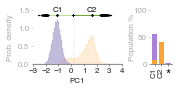

In [47]:
from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#68a92e','#bbe398','#88ce4b'])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


centers = np.array(clone_apoholo.centers)
labels = np.array(clone_apoholo.labels_)
labels_all = np.array(clone_apoholo.labels_all)
core = clone_apoholo.core_card

sns.despine(left=True)
#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1.5])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,0.5, 1, 1.50])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2,  alpha=0.5)
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.2, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.6, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_tot[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[1.35]
# Plot clusters
ax1.axvline(x=0.2, color='#AAAAAA', linestyle='--', ymax=0.9, linewidth=0.2, zorder=-1)
ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=0.05, color='black', zorder=1, clip_on=False)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=False)

ax1.text(-1.45,1.45, "C1", fontsize=8)
ax1.text(1.2,1.45, "C2", fontsize=8)

#PLOT 2 
ax2.set_ylim([0,100])
ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_apo','weighted_cluster_relevance_holo']]
new_df.plot(kind='bar', legend=False, width=0.8, ax=ax2, color=['#faa336','#a782d9','black'], stacked=True)

ax2.set_xticklabels(["C1","C2", ""], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.text(2.01,-28,'*', ha='center', fontsize=14, color=axcolor)


#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=600, bbox_inches='tight')

0 99.98777456294063 0.012225437059374872 41.731573755994695 41.726471888711266 0.005101867283425734
1 12.67643947408191 87.32960556143267 56.2650930240468 7.132410462229176 49.13608380667324
-1 57.05782312925171 42.9421768707483 1.9999319751028877 1.141117649059556 0.8588143260433319


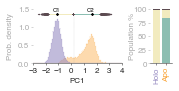

In [8]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in [0,1,-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:58800] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_), count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_)])
    print(label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100,count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_),count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_) )

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#8CBEB2','#F2EBBF', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


centers = np.array(clone_apoholo.centers)
labels = np.array(clone_apoholo.labels_)
labels_all = np.array(clone_apoholo.labels_all)
core = clone_apoholo.core_card

sns.despine(left=True)
#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1.5])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,0.5, 1, 1.50])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2,  alpha=0.5)
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.4, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.6, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_tot[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[1.35]
# Plot clusters
ax1.axvline(x=0.2, color='#AAAAAA', linestyle='--', ymax=0.9, linewidth=0.2, zorder=-1)
ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=0.05, color=color_list[2], zorder=1, clip_on=False)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=False)

ax1.text(-1.45,1.45, "C1", fontsize=6)
ax1.text(1.2,1.45, "C2", fontsize=6)

#PLOT 2 
ax2.set_ylim([0,50])
ax2.set_yticks([0,12.5,25,37.5,50])
ax2.set_yticklabels([0,25,50,75,100])
ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_holo','weighted_cluster_relevance_apo', ]]
new_df.transpose().plot(kind='bar', legend=False, width=0.8, ax=ax2, color=color_list, stacked=True)

ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")


#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=600, bbox_inches='tight')

(5881,)
(5881,)


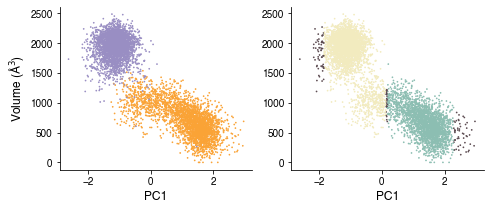

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(7.6,3), )

sns.despine()
vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
lab = clone_apoholo.labels_[::10]
print(np.shape(vol[0]))
print(np.shape(lab))
#plt.scatter(lab, vol[1], s=0.01)
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]
lab = [colorlist[0] if x==0 else x for x in lab]
lab = [colorlist[1] if x==1 else x for x in lab]
lab = [colorlist[2] if x==2 else x for x in lab]
lab = [colorlist[-1] if x==-1 else x for x in lab]
#lab
ax1.set_xlabel('PC1', fontsize=12)
ax2.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('Volume (\u212b$^3$)', fontsize=12)

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=['#FAA336']*2940+['#998EC3']*2941)
ax2.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=lab)

fig.savefig(output_folder+'/IMAGES/volume.png', dpi=600, bbox_inches='tight')


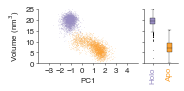

In [19]:

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(2.5,1),sharey=True)
plt.subplots_adjust(wspace=0.1)
color_list = np.array(['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


sns.despine(left=False)
#PLOT 1 
ax1.set_xlim([-4,5])
ax1.set_ylim([0,2500])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,500,1000,1500,2000,2500])
ax1.set_yticklabels([0,5,10,15,20,25])

ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel('Volume (nm$^3$)', fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor)  
ax1.spines['left'].set_color(axcolor)
ax1.spines['bottom'].set_color(axcolor)  
    
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], c=['#FAA336']*2941+['#998EC3']*2940, marker='o', s=0.2, linestyle='None',edgecolors=None, linewidths=0 )
    
    
#PLOT 2 
#ax2.set_ylim([0,50])
#ax2.set_yticks([])
#ax2.set_yticklabels([0,25,50,75,100])
#ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
#ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor)
ax2.spines['left'].set_color(axcolor)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")


vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
color = dict(boxes='black', whiskers='black', medians='red', caps='black')
data=[vol[1,2940:],vol[1,0:2940]]

boxprops = dict(linestyle='-', linewidth=0.3, color='black')
flierprops = dict(marker='o', markerfacecolor='black', linewidth=0.2, markersize=0.5, fillstyle='full', markeredgewidth=0.0)
medianprops = dict(linestyle='-', linewidth=0.3, color='black')
#meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
whiskerprops = dict(linestyle='-',linewidth=0.3, color='black')
capprops = dict(linewidth=0.3, color='black')


bp = ax2.boxplot(data, widths=0.3,patch_artist=True,
            flierprops=flierprops, 
            whiskerprops = whiskerprops,
            boxprops=boxprops,
            medianprops=medianprops,
            capprops=capprops)

colors=['#998EC3','#FAA336']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

fig.savefig(output_folder+'/IMAGES/volume_figure.png', dpi=600, bbox_inches='tight')